In [38]:
import matplotlib.pyplot as plt
import numpy as np
import flet as ft
import os
from pylsl import StreamInlet, resolve_stream
from scipy.signal import welch, spectrogram
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import pandas as pd
from joblib import dump
import pyxdf
from sklearn.model_selection import train_test_split
import seaborn as sns


In [39]:
# Combine all data stored in the same folder to use for training the model.
def concat_data(frequency):
    data_folder = f'../../../../data_ssvep/Toey/flicker1/{frequency}/'
    all_data = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        streams, _ = pyxdf.load_xdf(file_path)
        raw_data = streams[0]["time_series"].T
        all_data.append(raw_data)
    all_data_array = np.concatenate(all_data, axis=1)
    return all_data_array


In [40]:
# The stored data will be kept for an average of 80 seconds, so the data will be cut into parts. set_size is the sample that you want per 1 set. overlap is how much data in each set will overlap.
def create_overlapping_sets(data, set_size=500, overlap_fraction=0.5):
    step = int(set_size * (1 - overlap_fraction))
    sets = []
    for i in range(0, len(data) - set_size + 1, step):
        sets.append(data[i:i + set_size])
    return sets

In [41]:
name_data = 'psychopy'
raw_data1 = concat_data('6Hz')
print(raw_data1.shape)
raw_data2 = concat_data('20Hz')
print(raw_data2.shape)
raw_data3 = concat_data('0Hz')
print(raw_data3.shape)

(8, 164640)
(8, 166330)
(8, 167630)


In [42]:
# Store data in only 4 channels: Oz Pz O1 O2
data1 = raw_data1[0:4,:]
data2 = raw_data2[0:4,:]
data3 = raw_data3[0:4,:]
print(data1.shape)
print(data2.shape)
print(data3.shape)

(4, 164640)
(4, 166330)
(4, 167630)


In [43]:
# Adjust the reference using Pz as the channel ref.
data1_oz = data1[0] - data1[1]
data1_o1 = data1[2] - data1[1]
data1_o2 = data1[3] - data1[1]

data2_oz = data2[0] - data2[1]
data2_o1 = data2[2] - data2[1]
data2_o2 = data2[3] - data2[1]

data3_oz = data3[0] - data3[1]
data3_o1 = data3[2] - data3[1]
data3_o2 = data3[3] - data3[1]

print(data1_oz.shape, data1_o1.shape, data1_o2.shape)
print(data2_oz.shape, data2_o1.shape, data2_o2.shape)
print(data3_oz.shape, data3_o1.shape, data3_o2.shape)

(164640,) (164640,) (164640,)
(166330,) (166330,) (166330,)
(167630,) (167630,) (167630,)


In [44]:
# The number seen is the number of members in the list, each member containing 1000 samples.
size = 1000
data1_set_oz = create_overlapping_sets(data1_oz, set_size=size, overlap_fraction=0.5)
data1_set_o1 = create_overlapping_sets(data1_o1, set_size=size, overlap_fraction=0.5)
data1_set_o2 = create_overlapping_sets(data1_o2, set_size=size, overlap_fraction=0.5)

data2_set_oz = create_overlapping_sets(data2_oz, set_size=size, overlap_fraction=0.5)
data2_set_o1 = create_overlapping_sets(data2_o1, set_size=size, overlap_fraction=0.5)
data2_set_o2 = create_overlapping_sets(data2_o2, set_size=size, overlap_fraction=0.5)

data3_set_oz = create_overlapping_sets(data3_oz, set_size=size, overlap_fraction=0.5)
data3_set_o1 = create_overlapping_sets(data3_o1, set_size=size, overlap_fraction=0.5)
data3_set_o2 = create_overlapping_sets(data3_o2, set_size=size, overlap_fraction=0.5)

In [45]:
print(len(data1_set_oz), len(data1_set_o1), len(data1_set_o2))
print(len(data2_set_oz), len(data2_set_o1), len(data2_set_o2))
print(len(data3_set_oz), len(data3_set_o1), len(data3_set_o2))

328 328 328
331 331 331
334 334 334


In [46]:
data1_fft_oz = []
data1_fft_o1 = []
data1_fft_o2 = []

data2_fft_oz = []
data2_fft_o1 = []
data2_fft_o2 = []

data3_fft_oz = []
data3_fft_o1 = []
data3_fft_o2 = []

In [47]:
# Convert signal to domain frequency
for i in range(len(data1_set_oz)):
    f, Pxx = welch(data1_set_oz[i], fs=250, nperseg= 250*4)
    data1_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data1_set_o1[i], fs=250, nperseg= 250*4)
    data1_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data1_set_o2[i], fs=250, nperseg= 250*4)
    data1_fft_o2.append(Pxx[0:121])

for i in range(len(data2_set_oz)):
    f, Pxx = welch(data2_set_oz[i], fs=250, nperseg= 250*4)
    data2_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data2_set_o1[i], fs=250, nperseg= 250*4)
    data2_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data2_set_o2[i], fs=250, nperseg= 250*4)
    data2_fft_o2.append(Pxx[0:121])

for i in range(len(data3_set_oz)):
    f, Pxx = welch(data3_set_oz[i], fs=250, nperseg= 250*4)
    data3_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data3_set_o1[i], fs=250, nperseg= 250*4)
    data3_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data3_set_o2[i], fs=250, nperseg= 250*4)
    data3_fft_o2.append(Pxx[0:121])

In [48]:
combined_data1 = np.hstack((data1_fft_oz, data1_fft_o1, data1_fft_o2))
combined_data2 = np.hstack((data2_fft_oz, data2_fft_o1, data2_fft_o2))
combined_data3 = np.hstack((data3_fft_oz, data3_fft_o1, data3_fft_o2))
combined_data = np.vstack((combined_data1, combined_data2, combined_data3))
labels = np.array([0]*len(data1_fft_oz) + [1]*len(data2_fft_oz) + [2]*len(data3_fft_oz))
print(combined_data.shape)
print(labels.shape)

(993, 363)
(993,)


In [49]:
# Divide data into train set and test set.
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(794, 363)
(199, 363)
(794,)
(199,)


Epoch 1/100


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5940 - loss: 1.0108   
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7763 - loss: 0.6644 
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8373 - loss: 0.5219 
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8507 - loss: 0.4349 
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8243 - loss: 0.4401 
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8640 - loss: 0.3767 
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8693 - loss: 0.3402 
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8771 - loss: 0.3064 
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8769 - loss: 0.3230 
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8946 - loss: 0.2912 
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8897 - loss: 0.2710 
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

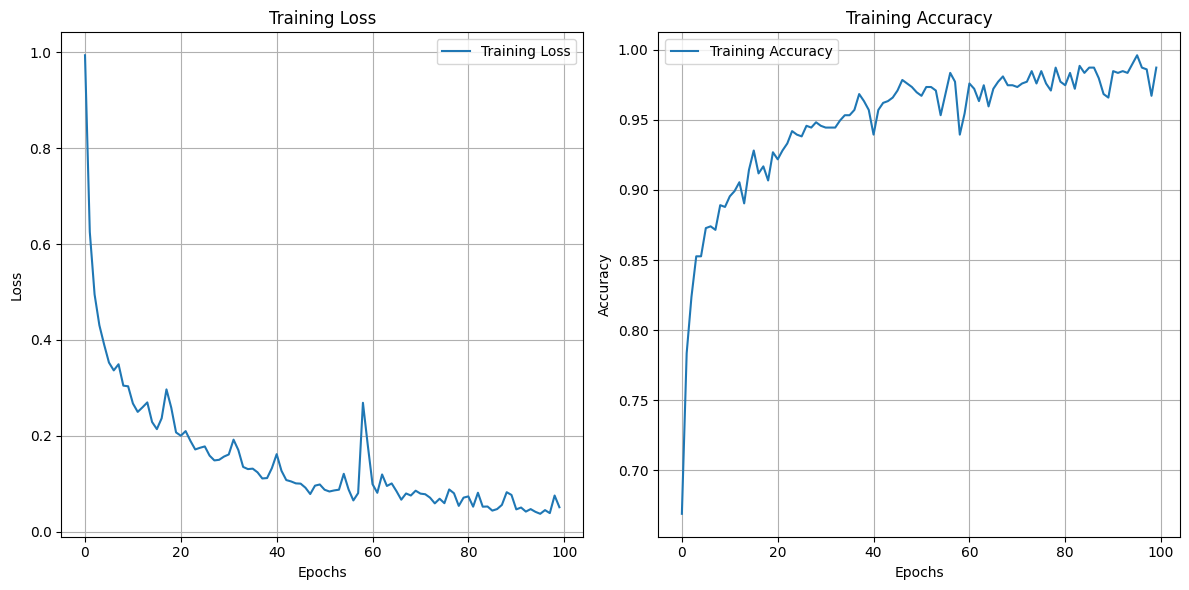

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.876712  0.955224  0.914286  0.876712
1          1.0   0.954545  0.940299  0.947368  0.954545
2          2.0   0.933333  0.861538  0.896000  0.933333
average    NaN   0.921412  0.919598  0.919451  0.919598


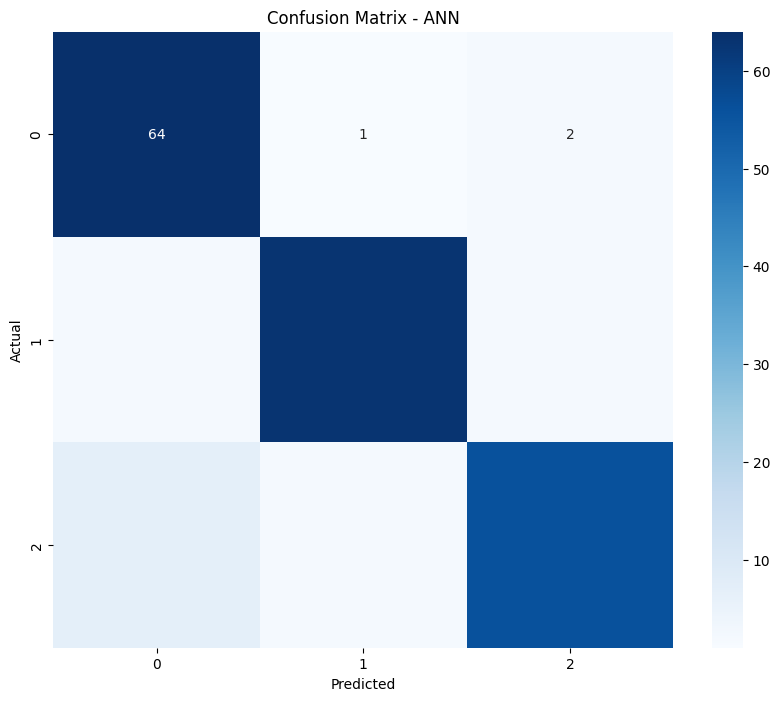

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# แปลง y_train และ y_test ให้เป็นแบบ one-hot encoding
num_classes = len(np.unique(y_train))
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# ann_model = Sequential([
#     Dense(128, input_dim=X_train.shape[1], activation='relu'),
#     Dropout(0.2),  # เพิ่ม Dropout เพื่อลดการ Overfitting
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(num_classes, activation='softmax')
# ])

# สร้างโมเดล ANN แบบ Feed-Forward
ann_model = Sequential()
ann_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dense(num_classes, activation='softmax'))

# คอมไพล์โมเดล
ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ฝึกโมเดล
ann_model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, verbose=1)

# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(ann_model.history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(ann_model.history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# ทำนายบน test set
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)

ann_model.save(f"model_FFT/ann_model_{name_data}.h5")



# ประเมิน precision, recall, และ F1-score ของแต่ละคลาส
precision_ann_per_class = precision_score(y_test, y_pred_ann, average=None)
recall_ann_per_class = recall_score(y_test, y_pred_ann, average=None)
f1_ann_per_class = f1_score(y_test, y_pred_ann, average=None)

# คำนวณ accuracy ของแต่ละคลาส
accuracy_ann_per_class = []
for class_label in range(len(precision_ann_per_class)):
    correct_predictions = ((y_pred_ann == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_ann == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_ann_per_class.append(accuracy)

# คำนวณค่าเฉลี่ยของ accuracy
avg_accuracy_ann = accuracy_score(y_test, y_pred_ann)

# เฉลี่ย precision, recall, และ F1-score ของแต่ละคลาส
avg_precision_ann = precision_score(y_test, y_pred_ann, average='weighted')
avg_recall_ann = recall_score(y_test, y_pred_ann, average='weighted')
avg_f1_ann = f1_score(y_test, y_pred_ann, average='weighted')

# สร้าง DataFrame จากผลลัพธ์
results_ann_df = pd.DataFrame({
    'Class': range(len(precision_ann_per_class)),
    'Precision': precision_ann_per_class,
    'Recall': recall_ann_per_class,
    'F1-score': f1_ann_per_class,
    'Accuracy': accuracy_ann_per_class
})

# เพิ่มค่าเฉลี่ยของ accuracy และ precision, recall, F1-score ลงในตาราง
results_ann_df.loc['average'] = [None, avg_precision_ann, avg_recall_ann, avg_f1_ann, avg_accuracy_ann]
print(results_ann_df)
conf_matrix_knn = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ANN')
plt.show()



Epoch 1/100


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5913 - loss: 1.5967
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8086 - loss: 0.7075
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8934 - loss: 0.3561
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8684 - loss: 0.3059
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8891 - loss: 0.3218
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9136 - loss: 0.2968
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9218 - loss: 0.2477
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9375 - loss: 0.1904
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9100 - loss: 0.2443
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9446 - loss: 0.1326
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9522 - loss: 0.1292
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy:

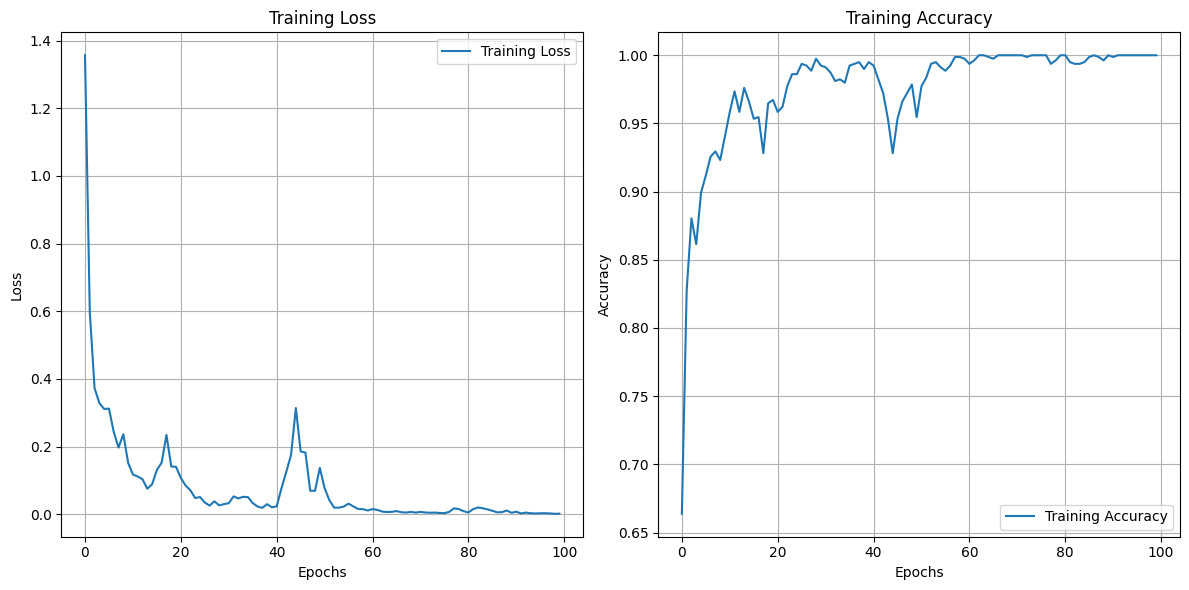

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.828947  0.940299  0.881119  0.828947
1          1.0   0.925373  0.925373  0.925373  0.925373
2          2.0   0.892857  0.769231  0.826446  0.892857
average    NaN   0.882287  0.879397  0.878161  0.879397


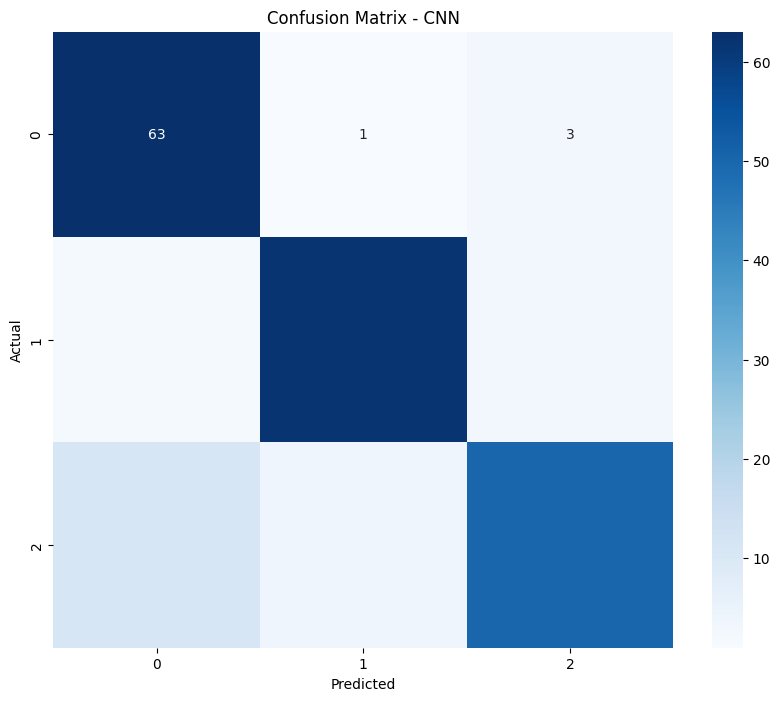

In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dense, ReLU, Softmax, Flatten
from tensorflow.keras.utils import to_categorical

# แบ่งข้อมูลเป็น train set และ test set
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)

# Normalize ข้อมูล
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# ปรับข้อมูลให้เป็นรูปแบบ 3D สำหรับ Conv1D
X_train_reshaped = X_train.reshape(-1, 363, 1)
X_test_reshaped = X_test.reshape(-1, 363, 1)

# สร้างโมเดล CNN สำหรับข้อมูล 1D
model = Sequential()

# Convolution Layer
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(363, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(ReLU())

# เพิ่มอีก Convolution Layer
model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(ReLU())

# Dense Layer
model.add(Flatten())
model.add(Dense(units=256))
model.add(ReLU())

# Output Layer
num_classes = len(np.unique(y_train))
model.add(Dense(units=num_classes))
model.add(Softmax())

# คอมไพล์โมเดล
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# แปลง y_train และ y_test ให้เป็นแบบ one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# ฝึกโมเดล
model.fit(X_train_reshaped, y_train_one_hot, epochs=100, batch_size=32, verbose=1)

# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ทำนายบน test set
y_pred_cnn = np.argmax(model.predict(X_test_reshaped), axis=1)

dump(scaler, f'model_FFT/cnn_scaler_{name_data}.pkl')
model.save(f"model_FFT/cnn_model_{name_data}.h5")

# ประเมิน precision, recall, และ F1-score ของแต่ละคลาส
precision_cnn_per_class = precision_score(y_test, y_pred_cnn, average=None)
recall_cnn_per_class = recall_score(y_test, y_pred_cnn, average=None)
f1_cnn_per_class = f1_score(y_test, y_pred_cnn, average=None)

# คำนวณ accuracy ของแต่ละคลาส
accuracy_cnn_per_class = []
for class_label in range(len(precision_cnn_per_class)):
    correct_predictions = ((y_pred_cnn == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_cnn == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_cnn_per_class.append(accuracy)

# คำนวณค่าเฉลี่ยของ accuracy
avg_accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

# เฉลี่ย precision, recall, และ F1-score ของแต่ละคลาส
avg_precision_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
avg_recall_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
avg_f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')

# สร้าง DataFrame จากผลลัพธ์
results_cnn_df = pd.DataFrame({
    'Class': range(len(precision_cnn_per_class)),
    'Precision': precision_cnn_per_class,
    'Recall': recall_cnn_per_class,
    'F1-score': f1_cnn_per_class,
    'Accuracy': accuracy_cnn_per_class
})


# เพิ่มค่าเฉลี่ยของ accuracy และ precision, recall, F1-score ลงในตาราง
results_cnn_df.loc['average'] = [None, avg_precision_cnn, avg_recall_cnn, avg_f1_cnn, avg_accuracy_cnn]
print(results_cnn_df)
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.show()


Epoch 1/100


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 0.3365 - loss: 1.1267 - val_accuracy: 0.3367 - val_loss: 1.1164 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.3366 - loss: 1.1177 - val_accuracy: 0.3367 - val_loss: 1.1116 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.3590 - loss: 1.1051 - val_accuracy: 0.4221 - val_loss: 1.0477 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.4287 - loss: 1.0200 - val_accuracy: 0.5729 - val_loss: 1.0029 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.5961 - loss: 1.0031 - val_accuracy: 0.6533 - val_loss: 0.9798 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.6223 - loss: 0.9701 - val_accuracy: 0.6231 - val_loss: 0.9554 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.6430 - loss: 0.9638 - val_

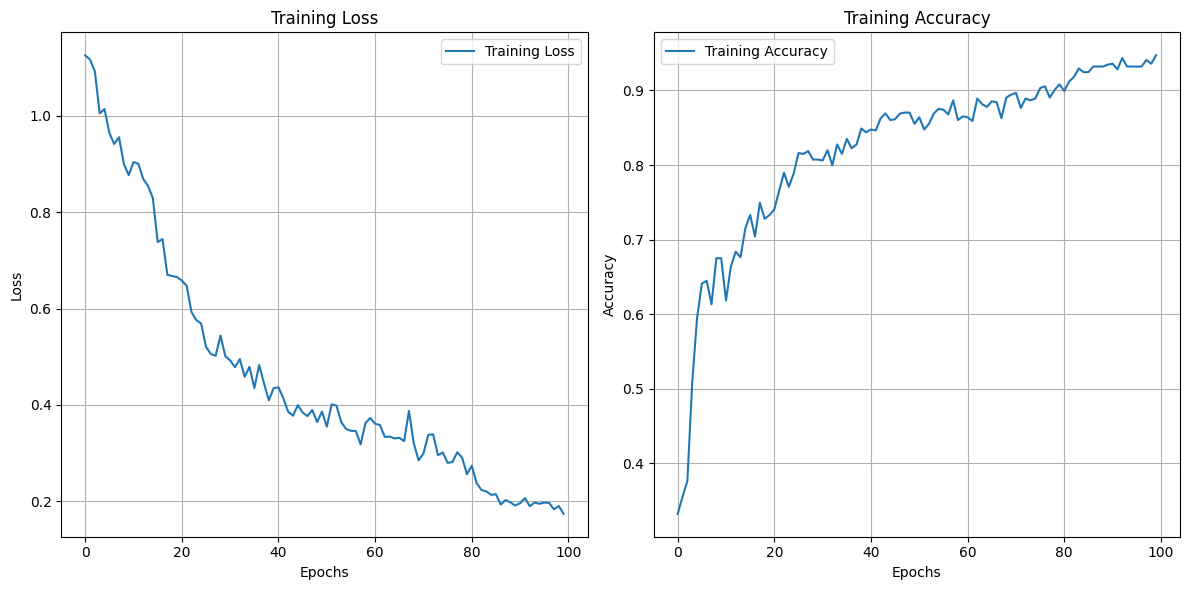

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.939394  0.939394  0.939394  0.939394
1          1.0   0.953846  0.939394  0.946565  0.953846
2          2.0   0.911765  0.925373  0.918519  0.911765
average    NaN   0.934885  0.934673  0.934744  0.934673


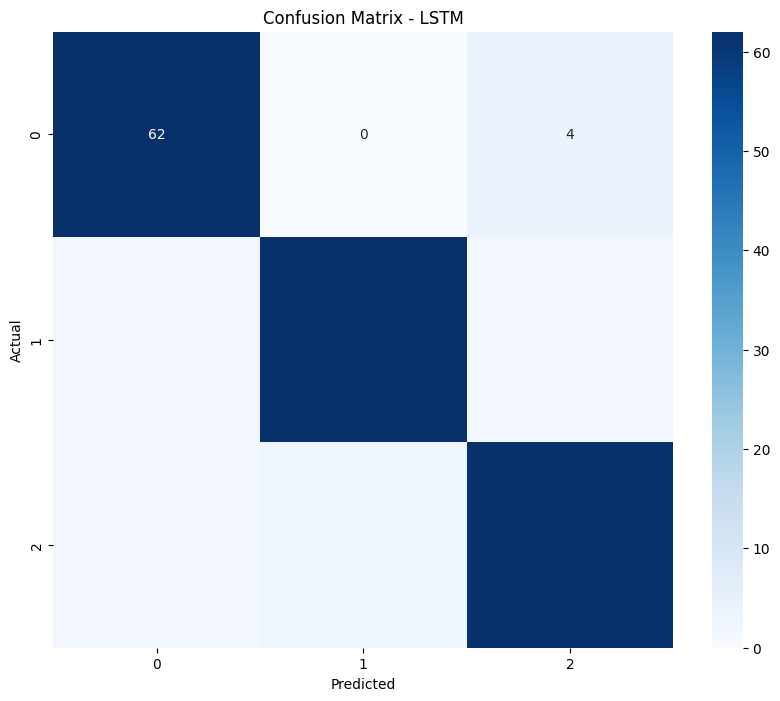

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# แบ่งข้อมูลเป็น train set และ test set
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42, stratify=labels)

# Normalize ข้อมูล
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ปรับข้อมูลให้เป็นรูปแบบ 3D สำหรับ LSTM
X_train_reshaped = X_train.reshape(-1, 363, 1)
X_test_reshaped = X_test.reshape(-1, 363, 1)

# สร้างโมเดล LSTM
model = Sequential()

# LSTM Layer 1
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(363, 1), kernel_regularizer=l2(0.0001))))
model.add(Dropout(0.3))

# LSTM Layer 2
model.add(Bidirectional(LSTM(70, return_sequences=False, kernel_regularizer=l2(0.0001))))
model.add(Dropout(0.3))

# Fully Connected Layer
model.add(Dense(5, activation='relu'))

# Output Layer with Softmax
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# คอมไพล์โมเดล
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# แปลง y_train และ y_test ให้เป็นแบบ one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_train)))

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# ฝึกโมเดล
model.fit(X_train_reshaped, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test_reshaped, y_test_one_hot), callbacks=[reduce_lr, early_stopping], verbose=1)
# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
model.save(f"model_FFT/lstm_model_{name_data}.h5")
dump(scaler, f'model_FFT/lstm_scaler_{name_data}.pkl')

# ทำนายบน test set
y_pred_lstm = np.argmax(model.predict(X_test_reshaped), axis=1)

# ประเมิน precision, recall, และ F1-score ของแต่ละคลาส
precision_lstm_per_class = precision_score(y_test, y_pred_lstm, average=None)
recall_lstm_per_class = recall_score(y_test, y_pred_lstm, average=None)
f1_lstm_per_class = f1_score(y_test, y_pred_lstm, average=None)

# คำนวณ accuracy ของแต่ละคลาส
accuracy_lstm_per_class = []
for class_label in range(len(precision_lstm_per_class)):
    correct_predictions = ((y_pred_lstm == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_lstm == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_lstm_per_class.append(accuracy)

# คำนวณค่าเฉลี่ยของ accuracy
avg_accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

# เฉลี่ย precision, recall, และ F1-score ของแต่ละคลาส
avg_precision_lstm = precision_score(y_test, y_pred_lstm, average='weighted')
avg_recall_lstm = recall_score(y_test, y_pred_lstm, average='weighted')
avg_f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted')

# สร้าง DataFrame จากผลลัพธ์
results_lstm_df = pd.DataFrame({
    'Class': range(len(precision_lstm_per_class)),
    'Precision': precision_lstm_per_class,
    'Recall': recall_lstm_per_class,
    'F1-score': f1_lstm_per_class,
    'Accuracy': accuracy_lstm_per_class
})

# เพิ่มค่าเฉลี่ยของ accuracy และ precision, recall, F1-score ลงในตาราง
results_lstm_df.loc['average'] = [None, avg_precision_lstm, avg_recall_lstm, avg_f1_lstm, avg_accuracy_lstm]

print(results_lstm_df)


conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()


Epoch 1/100


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4964 - loss: 5.7367 - val_accuracy: 0.5786 - val_loss: 4.0292
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7283 - loss: 3.7951 - val_accuracy: 0.6730 - val_loss: 3.2606
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7405 - loss: 3.1084 - val_accuracy: 0.7610 - val_loss: 2.8252
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7817 - loss: 2.4389 - val_accuracy: 0.6226 - val_loss: 2.6020
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8168 - loss: 2.2217 - val_accuracy: 0.7610 - val_loss: 2.3153
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8233 - loss: 2.0418 - val_accuracy: 0.5535 - val_loss: 2.1810
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8135 - loss: 1.7477 - val_accuracy: 0.7799 - val_loss: 2.0472
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8165 - loss: 1.6972 - val_accuracy: 0.6792 - val_l

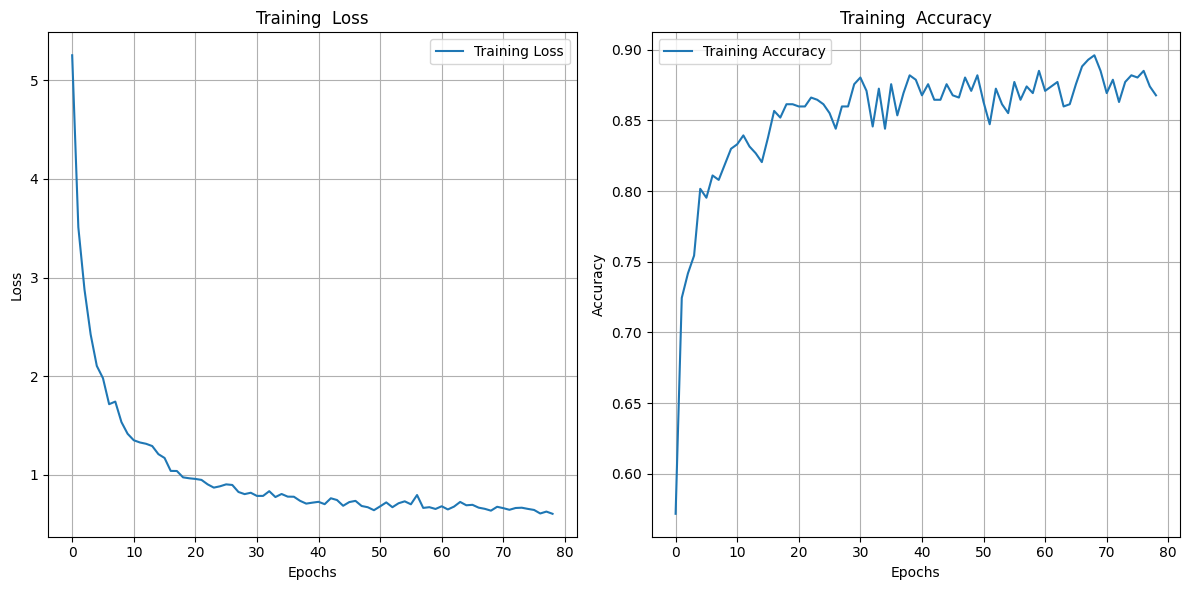

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.984375  0.940299  0.961832  0.984375
1          1.0   0.953846  0.925373  0.939394  0.953846
2          2.0   0.885714  0.953846  0.918519  0.885714
average    NaN   0.941871  0.939698  0.940130  0.939698


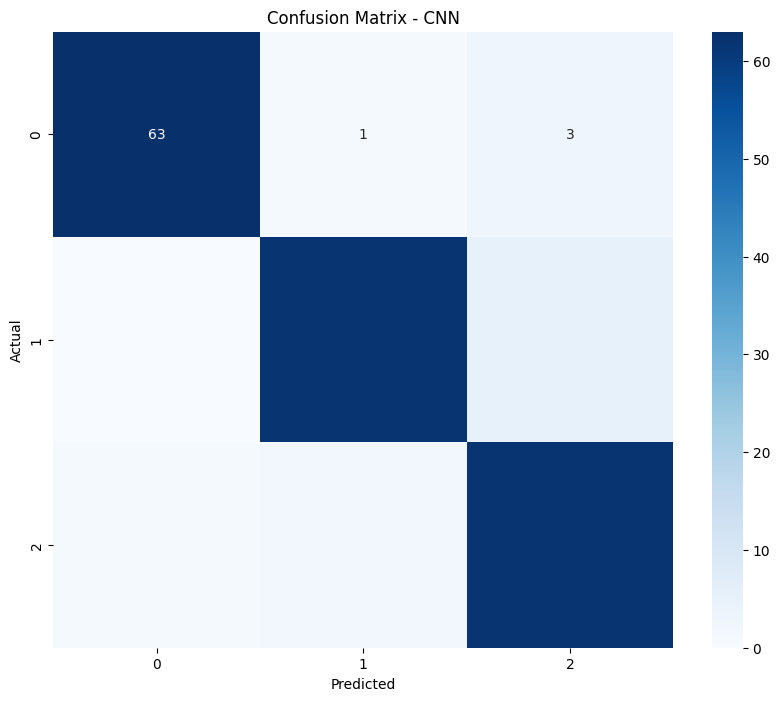

In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dense, ReLU, Softmax, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# # Load your data
# combined_data = # Load your data here
# labels = # Load your labels here

# # แบ่งข้อมูลเป็น train set และ test set
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)

# Normalize ข้อมูล
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ปรับข้อมูลให้เป็นรูปแบบ 3D สำหรับ Conv1D
X_train_reshaped = X_train.reshape(-1, 363, 1)
X_test_reshaped = X_test.reshape(-1, 363, 1)

# สร้างโมเดล CNN สำหรับข้อมูล 1D
model = Sequential()

# Convolution Layer
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(363, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(ReLU())
model.add(Dropout(0.5))

# เพิ่มอีก Convolution Layer
model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(ReLU())
model.add(Dropout(0.5))

# Dense Layer
model.add(Flatten())
model.add(Dense(units=256, kernel_regularizer='l2'))
model.add(ReLU())
model.add(Dropout(0.5))

# Output Layer
num_classes = len(np.unique(y_train))
model.add(Dense(units=num_classes))
model.add(Softmax())

# คอมไพล์โมเดล
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# แปลง y_train และ y_test ให้เป็นแบบ one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ฝึกโมเดล
history = model.fit(X_train_reshaped, y_train_one_hot, epochs=100, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training  Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training  Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ทำนายบน test set
y_pred_cnn = np.argmax(model.predict(X_test_reshaped), axis=1)

# Evaluate precision, recall, and F1-score per class
precision_cnn_per_class = precision_score(y_test, y_pred_cnn, average=None)
recall_cnn_per_class = recall_score(y_test, y_pred_cnn, average=None)
f1_cnn_per_class = f1_score(y_test, y_pred_cnn, average=None)

# Compute accuracy per class
accuracy_cnn_per_class = []
for class_label in range(len(precision_cnn_per_class)):
    correct_predictions = ((y_pred_cnn == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_cnn == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_cnn_per_class.append(accuracy)

# Compute average accuracy
avg_accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

# Compute weighted average precision, recall, and F1-score
avg_precision_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
avg_recall_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
avg_f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')

# Create a DataFrame to display the results
results_cnn_df = pd.DataFrame({
    'Class': range(len(precision_cnn_per_class)),
    'Precision': precision_cnn_per_class,
    'Recall': recall_cnn_per_class,
    'F1-score': f1_cnn_per_class,
    'Accuracy': accuracy_cnn_per_class
})

# Add average metrics to the DataFrame
results_cnn_df.loc['average'] = [None, avg_precision_cnn, avg_recall_cnn, avg_f1_cnn, avg_accuracy_cnn]
print(results_cnn_df)

# Plot confusion matrix
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.show()

# Save the scaler and model
from joblib import dump
dump(scaler, f'model_FFT/cnn_scaler_{name_data}_2.pkl')
model.save(f"model_FFT/cnn_model_{name_data}_2.h5")
